# Plotting the predictions of the single- and multi-center RPN signatures
- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/3_compare_predictions.ipynb
- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature
- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3
- Raw data from center 3 is available upon reasonable request.

## Imports

In [34]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from mlxtend.evaluate import permutation_test
from scipy.stats import f_oneway
from scipy import stats

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

from tqdm import tqdm

## Load and merge behavioral data for all three centers (after exclusions)

In [2]:
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

## Load predictions for the original single-center and the newly proposed multi-center model

In [3]:
# predictions
multicener_predictions = np.genfromtxt('../res/multi-center/nested_cv_pred_full_GroupKFold30.csv', delimiter=',')
rpn_predictions = np.hstack((df_bochum.nested_prediction,
                            df_essen.prediction,
                            df_szeged.prediction))

predictions = {
    'single-center' : rpn_predictions,
    'multi-center' : multicener_predictions
}

### create study masks

In [4]:
study_masks = {
    "study 1" : (df.study == 'bochum').values,
    "study 2" : (df.study == 'essen').values,
    "study 3" : (df.study == 'szeged').values,
    "study 1+2+3" : np.array([True] * len(y))
}

## Observed vs. Predicted plots

*** single-center study 1 ****************************************************
R=0.45
p_corr=0.00363
MSE=0.43
MSE=0.46
Expl. Var. =0.185
*** single-center study 2 ****************************************************
R=0.43
p_corr=0.00325
MSE=0.54
MSE=0.59
Expl. Var. =0.181
*** single-center study 3 ****************************************************
R=0.47
p_corr=0.02300
MSE=0.44
MSE=0.57
Expl. Var. =0.170
*** single-center study 1+2+3 ****************************************************
R=0.42
p_corr=0.00013
MSE=0.47
MSE=0.54
Expl. Var. =0.164
*** multi-center study 1 ****************************************************
R=0.61
p_corr=0.00025
MSE=0.35
MSE=0.45
Expl. Var. =0.343
*** multi-center study 2 ****************************************************
R=0.59
p_corr=0.00000
MSE=0.42
MSE=0.54
Expl. Var. =0.340
*** multi-center study 3 ****************************************************
R=0.51
p_corr=0.01250
MSE=0.22
MSE=0.37
Expl. Var. =0.262
*** multi-center study 1+2+3 ***********

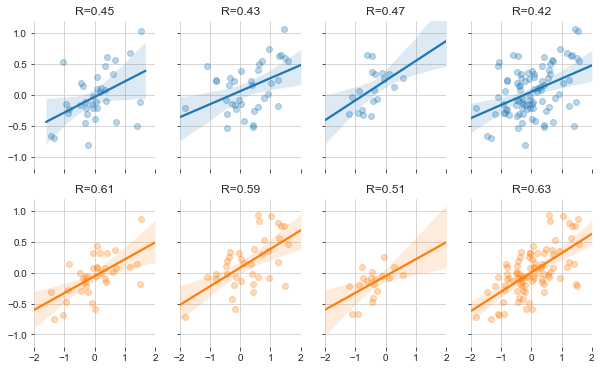

In [5]:
sns.set_style('ticks')
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(10,6), sharex=True, sharey=True)

cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(predictions.keys()):
    for col, study in enumerate(study_masks.keys()):
        g=sns.regplot(y[study_masks[study]], predictions[cv][study_masks[study]], ax=axs[row, col],
                    scatter=True, scatter_kws={'alpha':0.3}, color=cols[row])
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-1.2, 1.2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        axs[row, col].grid(True)
        
        print('***', cv, study, '****************************************************')
                   
        corr = np.corrcoef(y[study_masks[study]], predictions[cv][study_masks[study]])[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        print("R={:.2f}".format(corr))
        
        # takes some seconds
        p_corr = permutation_test(y[study_masks[study]], predictions[cv][study_masks[study]],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
        print("p_corr={:.5f}".format(p_corr))
        
        mse = mean_squared_error(y[study_masks[study]], predictions[cv][study_masks[study]])
        print("MSE={:.2f}".format(mse))
        
        mae = mean_absolute_error(y[study_masks[study]], predictions[cv][study_masks[study]])
        print("MSE={:.2f}".format(mae))
        
        expvar = explained_variance_score(y[study_masks[study]], predictions[cv][study_masks[study]])
        print("Expl. Var. ={:.3f}".format(expvar))
   
   
        
plt.savefig('../res/multi-center/regplots_obs-pred.pdf')  

## Violoin plots per center for the observed and predicted values

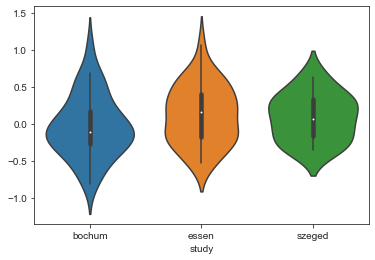

In [6]:
sns.violinplot(data=df, x='study', y=predictions['single-center'])

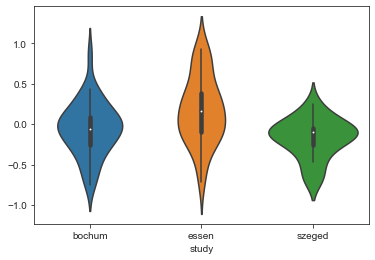

In [7]:
sns.violinplot(data=df, x='study', y=predictions['multi-center'])

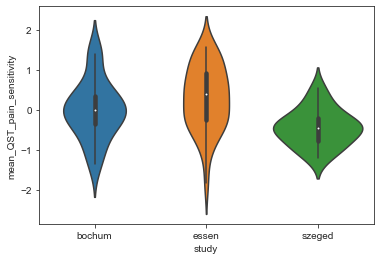

In [8]:
sns.violinplot(data=df, x='study', y='mean_QST_pain_sensitivity')

In [9]:
print(df.mean_QST_pain_sensitivity[df.study=='bochum'].mean())
print(df.mean_QST_pain_sensitivity[df.study=='essen'].mean())
print(df.mean_QST_pain_sensitivity[df.study=='szeged'].mean())

f_oneway(df.mean_QST_pain_sensitivity[df.study=='bochum'],
        df.mean_QST_pain_sensitivity[df.study=='essen'],
        df.mean_QST_pain_sensitivity[df.study=='szeged'])

0.008551403888578259
0.289473414953464
-0.435775823593041


F_onewayResult(statistic=6.5055415995744355, pvalue=0.00231739640326624)

## Remove main site effect from observed pain sensitivity and re-calculate measures

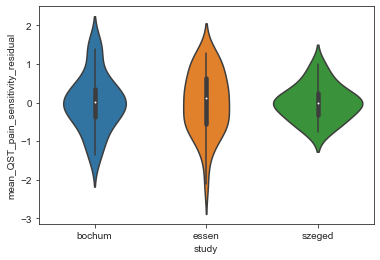

In [10]:
y_res = np.copy(y.values)
y_res[df.study=='bochum'] -= np.mean(y_res[df.study=='bochum'])
y_res[df.study=='essen'] -= np.mean(y_res[df.study=='essen'])
y_res[df.study=='szeged'] -= np.mean(y_res[df.study=='szeged'])

df['mean_QST_pain_sensitivity_residual'] = y_res
sns.violinplot(data=df, x='study', y='mean_QST_pain_sensitivity_residual')

*** single-center study 1 ****************************************************
R=0.45
p_corr=0.00350
MSE=0.42
MSE=0.46
Expl. Var. =0.185
*** single-center study 2 ****************************************************
R=0.43
p_corr=0.00325
MSE=0.52
MSE=0.56
Expl. Var. =0.181
*** single-center study 3 ****************************************************
R=0.47
p_corr=0.02063
MSE=0.17
MSE=0.33
Expl. Var. =0.170
*** single-center study 1+2+3 ****************************************************
R=0.43
p_corr=0.00000
MSE=0.41
MSE=0.48
Expl. Var. =0.172
*** multi-center study 1 ****************************************************
R=0.61
p_corr=0.00025
MSE=0.34
MSE=0.45
Expl. Var. =0.343
*** multi-center study 2 ****************************************************
R=0.59
p_corr=0.00000
MSE=0.44
MSE=0.54
Expl. Var. =0.340
*** multi-center study 3 ****************************************************
R=0.51
p_corr=0.01375
MSE=0.18
MSE=0.33
Expl. Var. =0.262
*** multi-center study 1+2+3 ***********

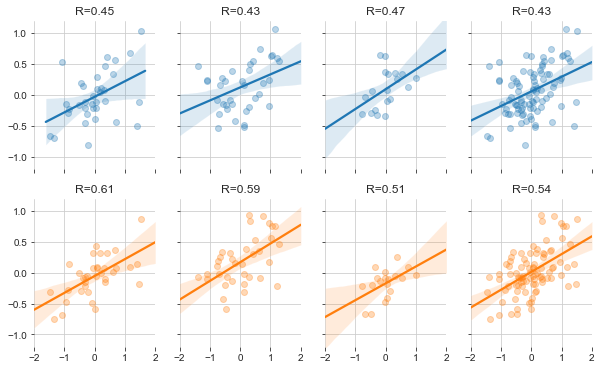

In [11]:
sns.set_style('ticks')
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(10,6), sharex=True, sharey=True)

cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(predictions.keys()):
    for col, study in enumerate(study_masks.keys()):
        g=sns.regplot(y_res[study_masks[study]], predictions[cv][study_masks[study]], ax=axs[row, col],
                    scatter=True, scatter_kws={'alpha':0.3}, color=cols[row])
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-1.2, 1.2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        axs[row, col].grid(True)
        
        print('***', cv, study, '****************************************************')
                   
        corr = np.corrcoef(y_res[study_masks[study]], predictions[cv][study_masks[study]])[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        print("R={:.2f}".format(corr))
        
        # takes some seconds
        p_corr = permutation_test(y_res[study_masks[study]], predictions[cv][study_masks[study]],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
        print("p_corr={:.5f}".format(p_corr))
        
        mse = mean_squared_error(y_res[study_masks[study]], predictions[cv][study_masks[study]])
        print("MSE={:.2f}".format(mse))
        
        mae = mean_absolute_error(y_res[study_masks[study]], predictions[cv][study_masks[study]])
        print("MSE={:.2f}".format(mae))
        
        expvar = explained_variance_score(y_res[study_masks[study]], predictions[cv][study_masks[study]])
        print("Expl. Var. ={:.3f}".format(expvar))
   
   
        
plt.savefig('../res/multi-center/regplots_obs_resid-pred.pdf')  

## Expected correlation with study

  0%|          | 14/100000 [00:00<12:18, 135.35it/s]

R^2_(observed ~ predicted) = 0.40124317724014147
R^2_(observed ~ C(confounder)) = 0.12880847118030403
R^2_(predicted ~ C(confounder) = 0.13557816071589912


100%|██████████| 100000/100000 [42:48<00:00, 38.93it/s]   


247
p= 0.08097165991902834


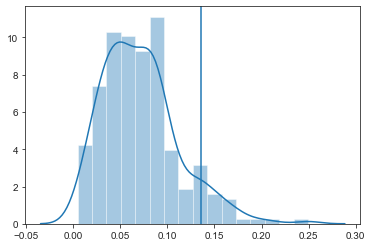

In [42]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#r_obs_pred = np.corrcoef(df.mean_QST_pain_sensitivity, predictions['multi-center'])[0,1]

data = pd.DataFrame(
    {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': df.study.astype("category").cat.codes.values
    })

fit=ols("observed ~ predicted", data=data).fit()
print("R^2_(observed ~ predicted) =", fit.rsquared)

fit=ols("observed ~ C(confounder)", data=data).fit()
print("R^2_(observed ~ C(confounder)) =", fit.rsquared)
r2_obs_conf_true = fit.rsquared

fit=ols("predicted ~ C(confounder)", data=data).fit()
print("R^2_(predicted ~ C(confounder) =", fit.rsquared)
r2_pred_conf_true = fit.rsquared


corrs=[]
nulldata=[]

rng = np.random.default_rng(42)

for i in tqdm(range(100000)):
    data_rs = pd.DataFrame(
    {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': rng.permutation(df.study.astype("category").cat.codes.values)
    })
    r2_obs_conf_rs = ols("observed ~ C(confounder)", data=data_rs).fit().rsquared
    
    if (r2_obs_conf_rs >= r2_obs_conf_true):
        #print("Resampled R^2_(observed ~ C(confounder)) =", r2_obs_conf_rs)
        fit=ols("predicted ~ C(confounder)", data=data_rs).fit()
        #print("Resampled  R^2_(predicted ~ C(confounder) =", fit.rsquared)
        
        nulldata.append(fit.rsquared)
        corrs.append(r2_obs_conf_rs)
        
sns.distplot(nulldata)
plt.axvline(r2_pred_conf_true)

print(len(nulldata))
print("p=", np.sum(nulldata>=r2_pred_conf_true)/len(nulldata))

        
    

In [47]:
np.sqrt(0.12)

0.34641016151377546

In [96]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#r_obs_pred = np.corrcoef(df.mean_QST_pain_sensitivity, predictions['multi-center'])[0,1]

data = pd.DataFrame(
    {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': df.study.astype("category").cat.codes.values
    })

fit=ols("observed ~ predicted", data=data).fit()
print("R^2_(observed ~ predicted) =", fit.rsquared)

fit=ols("observed ~ C(confounder)", data=data).fit()
print("R^2_(observed ~ C(confounder)) =", fit.rsquared)
r2_obs_conf_true = fit.rsquared

fit=ols("predicted ~ C(confounder)", data=data).fit()
print("R^2_(predicted ~ C(confounder) =", fit.rsquared)
r2_pred_conf_true = fit.rsquared


corrs=[]
nulldata=[]

tolerance = 0.01

rng = np.random.default_rng(42)

for i in tqdm(range(500000)):
    data_rs = pd.DataFrame(
    {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': rng.permutation(df.study.astype("category").cat.codes.values)
    })
    r2_obs_conf_rs = ols("observed ~ C(confounder)", data=data_rs).fit().rsquared
    
    if (np.abs(r2_obs_conf_rs - r2_obs_conf_true) < tolerance):
        #print("Resampled R^2_(observed ~ C(confounder)) =", r2_obs_conf_rs)
        fit=ols("predicted ~ C(confounder)", data=data_rs).fit()
        #print("Resampled  R^2_(predicted ~ C(confounder) =", fit.rsquared)
        print(data_rs.confounder.values)
        
        nulldata.append(fit.rsquared)
        corrs.append(r2_obs_conf_rs)
        
sns.distplot(nulldata)
plt.axvline(r2_pred_conf_true)

print(len(nulldata))
print("p=", np.sum(nulldata>=r2_pred_conf_true)/len(nulldata))

        
    


  0%|          | 6/500000 [00:00<2:33:13, 54.38it/s]

R^2_(observed ~ predicted) = 0.40124317724014147
R^2_(observed ~ C(confounder)) = 0.12880847118030403
R^2_(predicted ~ C(confounder) = 0.13557816071589912



  0%|          | 363/500000 [00:12<5:11:30, 26.73it/s]

[2 1 2 1 1 0 1 1 1 0 2 1 1 1 1 0 0 1 0 2 0 0 0 1 2 1 0 0 1 2 0 1 2 1 1 1 2
 2 0 0 2 1 1 1 2 2 1 2 1 1 0 0 0 2 2 0 0 2 0 0 1 0 0 0 1 1 0 1 0 0 0 2 1 0
 2 0 1 1 1 0 0 0 0 1 1 2 0 1 0 1 1]



  0%|          | 921/500000 [00:30<5:18:34, 26.11it/s]


  0%|          | 1291/500000 [00:43<4:24:49, 31.39it/s]

[1 1 2 2 2 0 0 1 1 0 1 1 1 0 0 0 2 0 0 2 1 0 0 2 1 1 0 0 1 2 1 1 0 2 2 0 1
 0 0 0 1 2 1 1 0 1 0 1 1 0 1 2 1 0 1 1 1 1 0 0 1 2 1 0 0 1 0 2 1 1 0 1 2 0
 1 2 0 2 0 1 2 2 0 0 1 1 0 1 0 0 2]



  0%|          | 1644/500000 [00:53<4:13:38, 32.75it/s]

[1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 2 0 1 0 1 1 2 1 1 2 1 1 2 2 2 1 1 2 2 1 2 0
 1 0 0 2 0 2 1 0 2 1 0 1 0 0 0 0 0 0 0 1 2 2 1 1 0 1 0 0 1 1 1 0 1 0 2 1 2
 1 0 0 2 1 0 0 0 0 0 1 2 0 0 0 2 1]



  0%|          | 1848/500000 [00:59<3:38:54, 37.93it/s]

[0 0 0 0 1 1 1 2 0 2 0 0 0 2 1 1 0 1 1 1 0 0 2 2 1 2 1 0 1 1 0 1 1 1 0 1 0
 0 2 1 1 1 0 1 2 0 2 0 0 0 1 0 0 2 0 1 2 1 1 2 0 2 1 0 1 1 1 2 0 1 1 1 1 0
 0 1 0 2 2 2 0 1 1 0 2 0 2 0 0 1 1]



  0%|          | 2112/500000 [01:07<4:53:57, 28.23it/s]

KeyboardInterrupt: 

permuting:   0%|          | 6/100000 [00:00<28:44, 57.98it/s]

R^2_(observed ~ predicted) = 0.40124317724014147
R^2_(observed ~ C(confounder)) = 0.12880847118030403
R^2_(predicted ~ C(confounder) = 0.13557816071589912


permuting: 100%|██████████| 100000/100000 [04:46<00:00, 349.47it/s]


2715
p= 0.02283609576427256


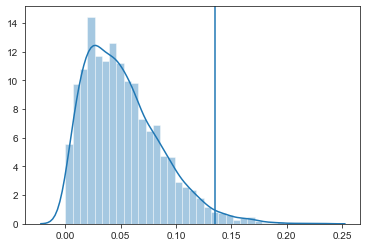

In [87]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import importlib
import contextlib
import joblib
from joblib import Parallel, delayed

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """
    Context manager to patch joblib to report into tqdm progress bar given as argument
    Based on: https://stackoverflow.com/questions/37804279/how-can-we-use-tqdm-in-a-parallel-execution-with-joblib
    """
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()
#r_obs_pred = np.corrcoef(df.mean_QST_pain_sensitivity, predictions['multi-center'])[0,1]

data = pd.DataFrame(
    {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': df.study.astype("category").cat.codes.values
    })

fit=ols("observed ~ predicted", data=data).fit()
print("R^2_(observed ~ predicted) =", fit.rsquared)

fit=ols("observed ~ C(confounder)", data=data).fit()
print("R^2_(observed ~ C(confounder)) =", fit.rsquared)
r2_obs_conf_true = fit.rsquared

fit=ols("predicted ~ C(confounder)", data=data).fit()
print("R^2_(predicted ~ C(confounder) =", fit.rsquared)
r2_pred_conf_true = fit.rsquared


corrs=[]
nulldata=[]

tolerance = 0.05



def workhorse(i):
    rng = np.random.default_rng(42+i)
    data_rs = pd.DataFrame(
        {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': rng.permutation(df.study.astype("category").cat.codes.values)
        })
    r2_obs_conf_rs = ols("observed ~ C(confounder)", data=data_rs).fit().rsquared
    
    if (np.abs(r2_obs_conf_rs - r2_obs_conf_true) < tolerance):
        #print("Resampled R^2_(observed ~ C(confounder)) =", r2_obs_conf_rs)
        fit=ols("predicted ~ C(confounder)", data=data_rs).fit()
        #print("Resampled  R^2_(predicted ~ C(confounder) =", fit.rsquared)     
        return fit.rsquared, r2_obs_conf_rs
    return np.nan, np.nan
    
num_perms=100000  
with tqdm_joblib(tqdm(desc='permuting', total=num_perms)) as progress_bar:
            res = Parallel(n_jobs=-1)(delayed(workhorse)(i) for i in np.arange(num_perms))
    

nulldata, corrs = zip(*res)
nulldata = np.array(nulldata)
nulldata = nulldata[~np.isnan(nulldata)]
print(len(nulldata))
sns.distplot(nulldata)
plt.axvline(r2_pred_conf_true)

print("p=", np.sum(nulldata>=r2_pred_conf_true)/len(nulldata))

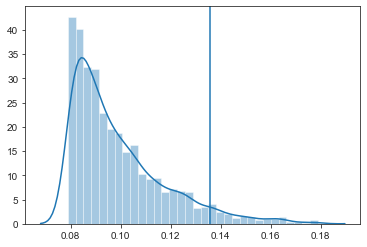

In [90]:
corrs = np.array(corrs)
sns.distplot(corrs[~np.isnan(corrs)])
plt.axvline(r2_pred_conf_true)

permuting:   0%|          | 0/1000000 [00:00<?, ?it/s]

R^2_(observed ~ predicted) = 0.40124317724014147
R^2_(observed ~ C(confounder)) = 0.12880847118030403
R^2_(predicted ~ C(confounder) = 0.13557816071589912


permuting: 100%|██████████| 1000000/1000000 [36:03<00:00, 462.32it/s] 


256
p= 0.03515625


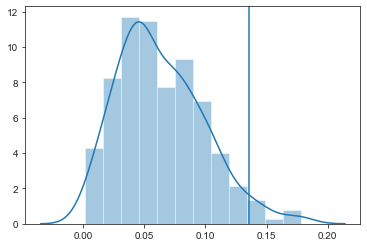

In [91]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import importlib
import contextlib
import joblib
from joblib import Parallel, delayed

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """
    Context manager to patch joblib to report into tqdm progress bar given as argument
    Based on: https://stackoverflow.com/questions/37804279/how-can-we-use-tqdm-in-a-parallel-execution-with-joblib
    """
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()
#r_obs_pred = np.corrcoef(df.mean_QST_pain_sensitivity, predictions['multi-center'])[0,1]

data = pd.DataFrame(
    {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': df.study.astype("category").cat.codes.values
    })

fit=ols("observed ~ predicted", data=data).fit()
print("R^2_(observed ~ predicted) =", fit.rsquared)

fit=ols("observed ~ C(confounder)", data=data).fit()
print("R^2_(observed ~ C(confounder)) =", fit.rsquared)
r2_obs_conf_true = fit.rsquared

fit=ols("predicted ~ C(confounder)", data=data).fit()
print("R^2_(predicted ~ C(confounder) =", fit.rsquared)
r2_pred_conf_true = fit.rsquared


corrs=[]
nulldata=[]

tolerance = 0.001



def workhorse(i):
    rng = np.random.default_rng(4242+i)
    data_rs = pd.DataFrame(
        {
        'observed': df.mean_QST_pain_sensitivity.values,
        'predicted': predictions['multi-center'],
        'confounder': rng.permutation(df.study.astype("category").cat.codes.values)
        })
    r2_obs_conf_rs = ols("observed ~ C(confounder)", data=data_rs).fit().rsquared
    
    if (np.abs(r2_obs_conf_rs - r2_obs_conf_true) < tolerance):
        #print("Resampled R^2_(observed ~ C(confounder)) =", r2_obs_conf_rs)
        fit=ols("predicted ~ C(confounder)", data=data_rs).fit()
        #print("Resampled  R^2_(predicted ~ C(confounder) =", fit.rsquared)     
        return fit.rsquared, r2_obs_conf_rs
    return np.nan, np.nan
    
num_perms=1000000  
with tqdm_joblib(tqdm(desc='permuting', total=num_perms)) as progress_bar:
            res = Parallel(n_jobs=-1)(delayed(workhorse)(i) for i in np.arange(num_perms))
    

nulldata, corrs = zip(*res)
nulldata = np.array(nulldata)
nulldata = nulldata[~np.isnan(nulldata)]
print(len(nulldata))
sns.distplot(nulldata)
plt.axvline(r2_pred_conf_true)

print("p=", np.sum(nulldata>=r2_pred_conf_true)/len(nulldata))

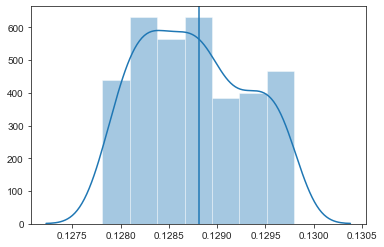

In [93]:
corrs = np.array(corrs)
sns.distplot(corrs[~np.isnan(corrs)])
plt.axvline(r2_obs_conf_true)

In [112]:
from scipy.stats import beta

def binom_interval(success, total, confint=0.95):
    quantile = (1 - confint) / 2.
    lower = beta.ppf(quantile, success, total - success + 1)
    upper = beta.ppf(1 - quantile, success + 1, total - success)
    return (lower, upper)

binom_interval(256*0.03515625, 256)

(0.016199410860957122, 0.06568621418387195)

## Predicted vs. Predicted plot

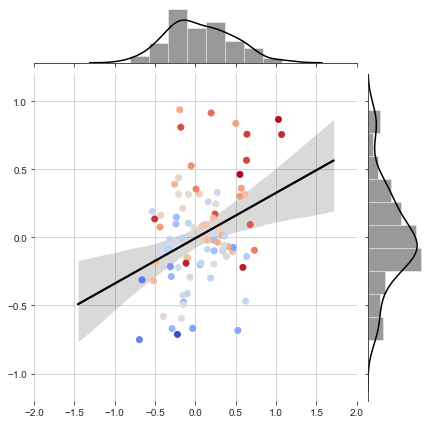

In [13]:
g=sns.jointplot(predictions['single-center'], predictions['multi-center'], kind='reg', color='black', scatter = False )
g.ax_joint.scatter(predictions['single-center'],predictions['multi-center'], c=df.mean_QST_pain_sensitivity,
                   cmap="coolwarm")
g.fig.set_size_inches(6,6)
g.ax_joint.set(xlabel=None) 
g.ax_joint.set_xlim([-2, 2])
g.ax_joint.set_ylim([-1.2, 1.2])
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['bottom'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)
g.ax_joint.spines['left'].set_visible(False)
g.ax_joint.grid(True)
plt.savefig('../res/multi-center/regplots_pred-pred.pdf')  

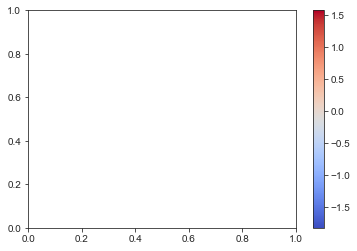

In [14]:
norm = plt.Normalize(df.mean_QST_pain_sensitivity.min(), df.mean_QST_pain_sensitivity.max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
plt.colorbar(sm)
plt.savefig('../res/multi-center/regplots_pred-pred_colorbar.pdf')  

In [15]:
corr = np.corrcoef(predictions['single-center'], predictions['multi-center'])[0,1]
print("R={:.2f}".format(corr))
        
# takes some seconds
p_corr = permutation_test(y[study_masks[study]], predictions[cv][study_masks[study]],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print("p_corr={:.5f}".format(p_corr))

R=0.35
p_corr=0.00000
